In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk

import string

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/Data/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.shape

(568454, 10)

# Data Preprocessing

In [4]:
df = df[["Score", "Text"]]

In [5]:
def map_sentiment(score):
    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

df['label'] = df['Score'].apply(map_sentiment)
df.drop('Score', inplace=True, axis=1)

In [6]:
df.head()

,Text,label
0,I have bought several of the Vitality canned d...,2
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,2
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,2


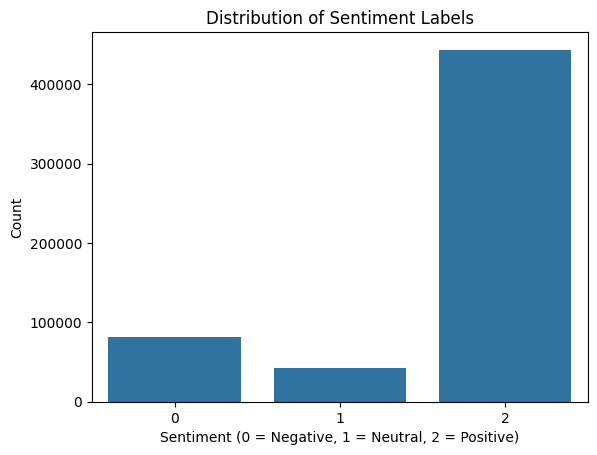

In [7]:
def plot_sent_labels_count(data, title=None):
    sns.countplot(data=data, x='label')
    plt.title(title)
    plt.xlabel('Sentiment (0 = Negative, 1 = Neutral, 2 = Positive)')
    plt.ylabel('Count')
    plt.show()

plot_sent_labels_count(data=df, title='Distribution of Sentiment Labels')

Undersampling Positive Sentiments

In [8]:
!pip install imbalanced-learn

In [9]:
X, y = df[['Text']].to_numpy(), df[['label']].to_numpy()

In [10]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='not minority')

X_resampled, y_resampled = undersample.fit_resample(X, y)

In [11]:
X_df_resampled = pd.Series(X_resampled.flatten(), name='Text')
y_df_resampled = pd.Series(y_resampled.flatten(), name='label')

resampled_df = pd.concat([X_df_resampled, y_df_resampled], axis=1)

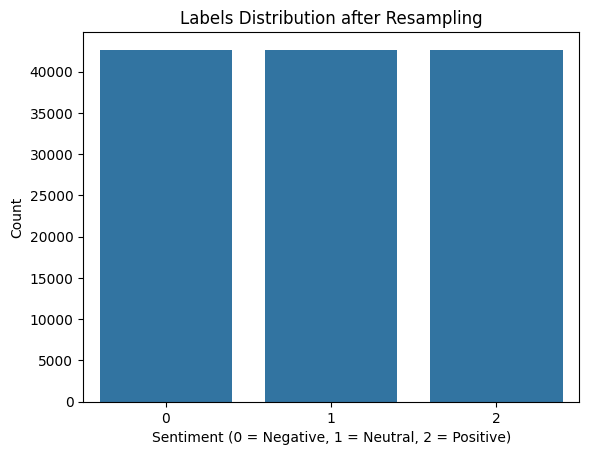

In [12]:
plot_sent_labels_count(data=resampled_df, title='Labels Distribution after Resampling')

#Model Training

##BERT Model

In [13]:
from transformers import BertTokenizerFast
from transformers import BertModel

model_id="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

###Preparing Data for BERT Model

tokenize data

In [14]:
def preprocess_tokenizer(examples):
    return tokenizer(examples["Text"], padding=True, truncation=True)

In [15]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [16]:
from datasets import Dataset

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(resampled_df)

# Tokenize with batching
tokenized_dataset = hf_dataset.map(preprocess_tokenizer, batched=True)

Map:   0%|          | 0/127920 [00:00<?, ? examples/s]

In [17]:
tokenized_dataset

Dataset({
    features: ['Text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 127920
})

Split Data

In [18]:
BATCH_SIZE = 8

In [19]:
# train-test split the dataset
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

# create Tensorflow dataset for train data
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size = BATCH_SIZE
)

# create Tensorflow dataset for test data
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size = BATCH_SIZE
)

Restructure Data Format for BERT Model

In [20]:
def restructure_data_format(data):
    return {
        'input_ids' : data['input_ids'],
        'token_type_ids' : data['token_type_ids'],
        'attention_mask' : data['attention_mask']
    }, data['label']

In [21]:
tf_train_dataset = tf_train_dataset.map(restructure_data_format).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.map(restructure_data_format).prefetch(tf.data.AUTOTUNE)

In [22]:
for i in tf_train_dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[ 101, 2065, 2017, ...,    0,    0,    0],
       [ 101, 2023, 4031, ...,    0,    0,    0],
       [ 101, 2026, 2990, ...,    0,    0,    0],
       ...,
       [ 101, 2057, 2074, ...,    0,    0,    0],
       [ 101, 2023, 1037, ...,    0,    0,    0],
       [ 101, 2205, 2919, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 0, 2, 0, 2, 0, 2, 0])>

###Modeling

In [23]:
from transformers import TFBertForSequenceClassification

model=TFBertForSequenceClassification.from_pretrained(model_id,num_labels=3)
model.summary()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training

In [ ]:
from transformers import create_optimizer

EPOCHS = 3
num_train_steps = (len(tokenized_dataset["train"]) // BATCH_SIZE) * EPOCHS
opt, _ = create_optimizer(init_lr=2e-5, num_train_steps=num_train_steps, num_warmup_steps=0)

Compiling

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=["accuracy"])

Fitting

In [ ]:
history = model.fit(tf_train_dataset.take(1000),
                    validation_data=tf_val_dataset,
                    epochs=EPOCHS)

Epoch 1/3
1000/1000 [==============================] - 2125s 2s/step - loss: 0.6657 - accuracy: 0.7103 - val_loss: 0.5581 - val_accuracy: 0.7631
Epoch 2/3
1000/1000 [==============================] - 2093s 2s/step - loss: 0.5562 - accuracy: 0.7680 - val_loss: 0.5351 - val_accuracy: 0.7731
Epoch 3/3
1000/1000 [==============================] - 2119s 2s/step - loss: 0.5128 - accuracy: 0.7937 - val_loss: 0.5245 - val_accuracy: 0.7766


Save BERT Model

In [28]:
import json

def save_history(model_history ,path):
    with open(path, 'w') as f:
        json.dump(model_history.history, f)

def load_history(file):
    with open(file, 'r') as f:
        return json.load(f)

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# save BERT model
model.save_pretrained("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model")

# save the tokenizer
# tokenizer.save_pretrained("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model")

# save model's history for comparison (later)
save_history(history, "/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/bert_training_history.json")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plot Model's Loss & Accuracy

In [30]:
def plot_val_train_loss(model_history, model_name=None):
    plt.plot(model_history["loss"])
    plt.plot(model_history["val_loss"])

    plt.title(f"{model_name} Model Loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.legend(["train loss", "val loss"], loc="lower left")
    plt.show()

In [31]:
def plot_val_train_acc(model_history, model_name=None):
    plt.plot(model_history["accuracy"])
    plt.plot(model_history["val_accuracy"])

    plt.title(f"{model_name} Model Accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.legend(["train accuracy", "val accuracy"], loc="lower left")
    plt.show()

In [26]:
bert = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/my_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


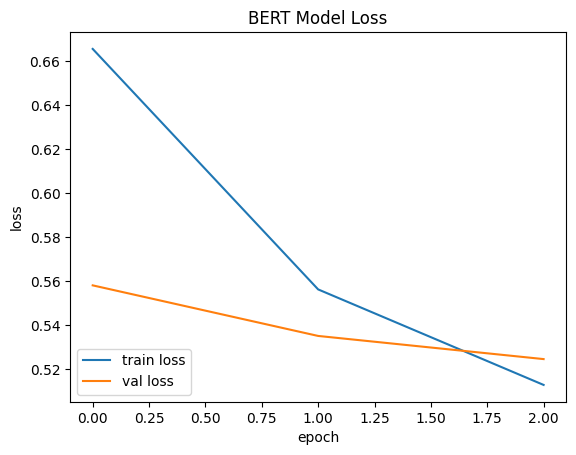

In [32]:
# loading BERT history
bert_history = load_history('/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/bert_training_history.json')

# plotting BERT loss
plot_val_train_loss(bert_history, 'BERT')

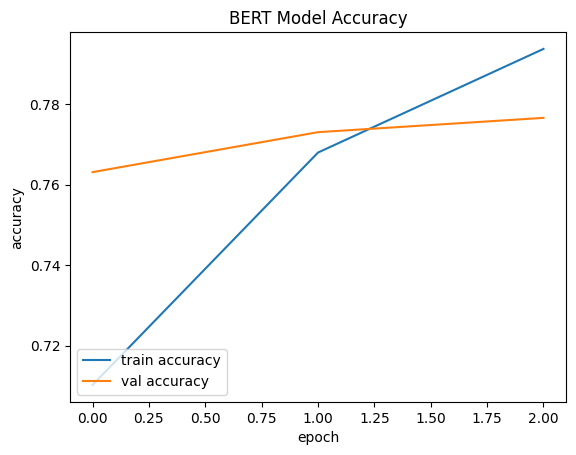

In [33]:
# plotting BERT Accuracy
plot_val_train_acc(bert_history, 'BERT')

##Naive Bayes

In [ ]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

def preprocess_text(text):
    # convert text to lower case
    text = text.lower()

    # remove punctuations
    translator = str.maketrans('','', string.punctuation)
    text = text.translate(translator)

    # tokenize words
    tokens = nltk.word_tokenize(text)

    # Stemming words
    stemmer = PorterStemmer()

    # creating a set for stopwords
    nltk.download('stopwords')
    stopwords_set = set(stopwords.words("english"))

    return [stemmer.stem(token) for token in tokens if token not in stopwords_set]

Prepare Data for Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vec = TfidfVectorizer(stop_words='english')
X_vect = vec.fit_transform(resampled_df['Text'])
y = resampled_df['label']

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)


Train Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

Model Evaluation